In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量 Tensors。
transform = transforms.Compose(
    [transforms.ToTensor(), # 将图片转换为Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # 将图片归一化，减去均值，除以标准差

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
# 测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
# 类别信息
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


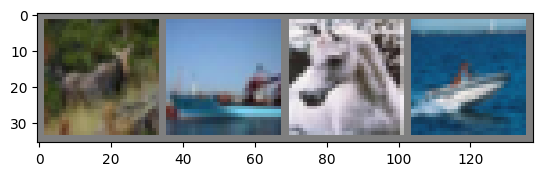

 deer  ship horse  ship


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 显示图片的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取一些训练图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:

import torch.nn as nn
import torch.nn.functional as F

# 定义一个卷积神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
import torch.optim as optim
# 定义损失函数和优化器
# 交叉熵损失函数和随机梯度下降优化器（使用momentum）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD随机梯度下降，lr学习率，momentum动量

In [10]:
for epoch in range(2):  # 循环遍历数据集多次
    # 每次训练一个batch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入
        inputs, labels = data
        # 将输入和标签迁移到GPU上
        inputs, labels = inputs.to(device), labels.to(device)
        # 梯度清零
        optimizer.zero_grad()

        # 向前+向后+优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 打印统计信息
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000个batch打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.203
[1,  4000] loss: 1.840
[1,  6000] loss: 1.659
[1,  8000] loss: 1.585
[1, 10000] loss: 1.516
[1, 12000] loss: 1.471
[2,  2000] loss: 1.388
[2,  4000] loss: 1.366
[2,  6000] loss: 1.333
[2,  8000] loss: 1.307
[2, 10000] loss: 1.299
[2, 12000] loss: 1.295
Finished Training


In [16]:
images = images.to(device)  # 将输入图像迁移到CUDA设备
outputs = net(images)
# 返回两个张量，一个是最大值，一个是最大值的索引
# 而最大值的索引就是预测的类别
_, predicted = torch.max(outputs, 1) # 输出预测结果

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   dog  deer horse


In [17]:
# 计算整个数据集的准确率
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 将输入和标签迁移到GPU上
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [18]:
# 计算每个类别的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) # 将输入图像迁移到CUDA设备
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 61 %
Accuracy of   car : 80 %
Accuracy of  bird : 36 %
Accuracy of   cat : 34 %
Accuracy of  deer : 47 %
Accuracy of   dog : 63 %
Accuracy of  frog : 54 %
Accuracy of horse : 63 %
Accuracy of  ship : 67 %
Accuracy of truck : 45 %


In [19]:
# 接下来我们将讨论如何在GPU上运行神经网络。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 确认我们的电脑支持CUDA，然后显示CUDA信息

print(device)

cuda:0
